In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv
/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv


## Data

Info about data

In [86]:
df_train = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-train.csv')
df_val = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-val.csv')
df_test = pd.read_csv('/kaggle/input/emotion-classification-nlp/emotion-labels-test.csv')

In [87]:
df_train

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
3608,@VivienLloyd Thank you so much! Just home - st...,sadness
3609,Just put the winter duvet on ☃️❄️🌬☔️,sadness
3610,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness
3611,@BluesfestByron second artist announcement loo...,sadness


## EDA

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

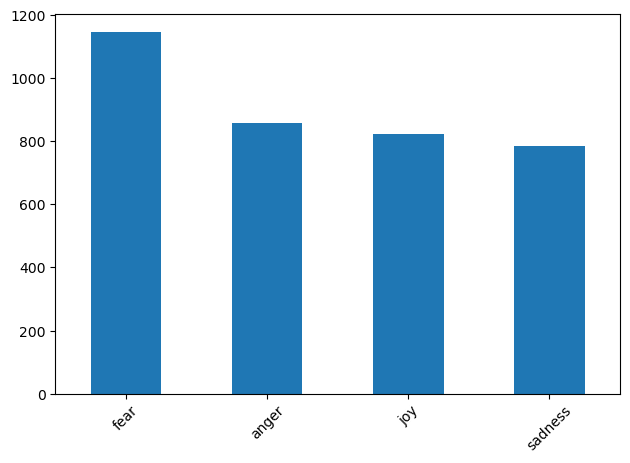

In [89]:
df_train['label'].value_counts().plot(kind = 'bar')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

## Data Cleaning

In [90]:
df_train['text']

0       Just got back from seeing @GaryDelaney in Burs...
1       Oh dear an evening of absolute hilarity I don'...
2       Been waiting all week for this game ❤️❤️❤️ #ch...
3       @gardiner_love : Thank you so much, Gloria! Yo...
4       I feel so blessed to work with the family that...
                              ...                        
3608    @VivienLloyd Thank you so much! Just home - st...
3609                Just put the winter duvet on ☃️❄️🌬☔️ 
3610    @SilkInSide @TommyJoeRatliff that's so pretty!...
3611    @BluesfestByron second artist announcement loo...
3612    I can literally eat creamy pesto pasta topped ...
Name: text, Length: 3613, dtype: object

### Removing Username Handles

In [91]:
import re

In [92]:
text = df_train['text'][0]
text

'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'

In [93]:
def remove_handle(text):
    string = re.sub(r"@\w+",' ', text)
    return string

In [94]:
remove_handle(text)

'Just got back from seeing   in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'

### Removing \# Marks

In [95]:
text = df_train['text'][0]
text

'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious'

In [96]:
def remove_hashtag(text):
    return re.sub(r' #',', ',text)

In [97]:
remove_hashtag(text)

'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much, hilarious'

### Parsing Emojis to their meaning | ♥ -> Heart

In [98]:
import emoji

In [99]:
text = df_train['text'][2]

In [100]:
def parse_emoji(text):
    return emoji.demojize(text)

In [101]:
parse_emoji(text)

'Been waiting all week for this game :red_heart::red_heart::red_heart: #cheer #friday :red_heart:'

In [102]:
df_train['text'] = df_train['text'].apply(remove_handle)
df_train['text'] = df_train['text'].apply(remove_hashtag)
df_train['text'] = df_train['text'].apply(parse_emoji)

## Word2Vec

In [103]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

df_train['text'] = df_train['text'].apply(simple_preprocess)


In [104]:
df_train['text']

0       [just, got, back, from, seeing, in, burslem, a...
1       [oh, dear, an, evening, of, absolute, hilarity...
2       [been, waiting, all, week, for, this, game, re...
3       [thank, you, so, much, gloria, you, re, so, sw...
4       [feel, so, blessed, to, work, with, the, famil...
                              ...                        
3608    [thank, you, so, much, just, home, stunned, bu...
3609    [just, put, the, winter, duvet, on, snowman, s...
3610    [that, so, pretty, love, the, sky, in, the, ba...
3611    [second, artist, announcement, looking, good, ...
3612    [can, literally, eat, creamy, pesto, pasta, to...
Name: text, Length: 3613, dtype: object

In [105]:
import gensim

In [106]:
import gensim.downloader as api

In [107]:
gensim.downloader.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [ ]:
model = api.load('word2vec-google-news-300')

In [ ]:
vocab = model.key_to_index.keys()

In [ ]:
X = df_train['text'].apply(lambda sent: model.get_mean_vector([word for word in sent if word in vocab]) )

In [ ]:
y = df_train['label'].map({'fear':0, 'anger':1, 'joy':2, 'sadness':3})

In [ ]:
X = np.vstack(X)

In [ ]:
def create_features(df):
    df['text'] = df['text'].apply(remove_handle)
    df['text'] = df['text'].apply(remove_hashtag)
    df['text'] = df['text'].apply(parse_emoji)
    df['text'] = df['text'].apply(simple_preprocess)
    X = df['text'].apply(lambda sent: model.get_mean_vector([word for word in sent if word in vocab]))
    X = np.vstack(X)
    y = df['label'].map({'fear':0, 'anger':1, 'joy':2, 'sadness':3})   
    return X, y
    

In [ ]:
X_val, y_val = create_features(df_val)

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='poly')

clf.fit(X, y)

print(clf)

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_val)

report = classification_report(y, y_val)

print(report)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X, y)


y_pred_rf = rf.predict(X_val)


report_rf = classification_report(y, y_val)


print(report_rf)


## Test Data

In [ ]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(X, y)


y_pred_lr = lr.predict(X)

report_lr = classification_report(y, y_val)

print(report_lr)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X, y)


y_pred_rf = rf.predict(X_val)


report_rf = classification_report(y, y_val)


print(report_rf)